In [5]:
import os
import numpy as np
import nibabel as nib
import sys
sys.path.append('..')
from train.augmentation import Transform
from tools.tools import show_mask
import torchio as tio
import napari
import tqdm
import matplotlib.pyplot as plt


In [2]:
img_path = '../data/kopf_SHIP/Kopf_t1_mpr_tra_iso_p2/'
label_path = '../data/kopf_SHIP/Kopf_t1_mpr_tra_iso_p2_label/'
img = nib.load(f'{img_path}/2025500102352.nii.gz').get_fdata()
print(img.shape)
labels = nib.load(f'{label_path}/2025500102352.nii').get_fdata()
print(labels.shape)

(176, 256, 176)
(176, 256, 176)


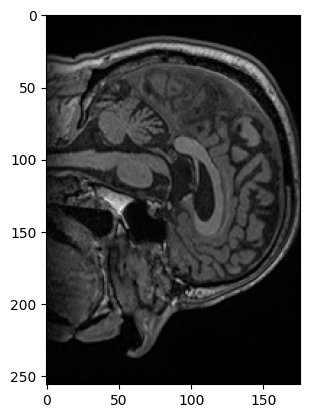

In [3]:
plt.imshow(img[88,:,:], 'gray')

### Test codes

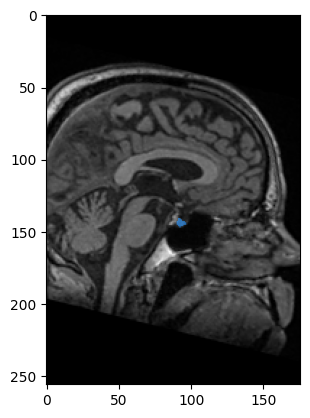

In [24]:
transform = Transform(img, labels)
#bri_img, bri_label = transform.adjust_brightness()
rot_img, rot_label = transform.random_rotate(degrees = (45,90))
#noise_img, noise_label = transform.add_noise()
#elas_img, elas_label = transform.elastic_transform()
plt.imshow(rot_img[88,:,:],'gray')
show_mask(rot_label[88,:,:],plt.gca())

In [25]:
x,y,z = np.where(rot_label > 0)
print(x.mean(),y.mean(),z.mean())
print(x.max(),y.max(),z.max())
print(x.min(),y.min(),z.min())

90.19364161849711 143.95664739884393 92.93352601156069
96 147 97
84 140 90


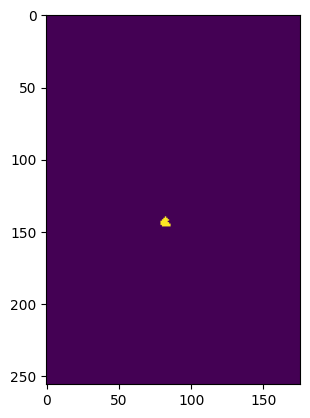

In [4]:
plt.imshow(rot_label[88,:,:])

In [15]:
viewer = napari.Viewer()
image1 = viewer.add_image(bri_img, name = 'bright')
label1 = viewer.add_labels(bri_label.astype(np.uint8), name= 'bright_label')
image2 = viewer.add_image(rot_img, name = 'rotate')
label2 = viewer.add_labels(rot_label.astype(np.uint8), name= 'rotate_label')
image3 = viewer.add_image(noise_img, name = 'noise')
label3 = viewer.add_labels(noise_label.astype(np.uint8), name= 'noise_label')
image4 = viewer.add_image(elas_img, name = 'elastic')
label4 = viewer.add_labels(elas_label.astype(np.uint8), name= 'elastic_label')


### Perform transformation

In [27]:
output = '../data/kopf_SHIP/augmentation'
n = 0
for file in tqdm.tqdm(os.listdir(label_path)):
    img = nib.load(f'{img_path}/{file}.gz').get_fdata()
    labels = nib.load(f'{label_path}/{file}').get_fdata()
    if n < 100:
        transform = Transform(img, labels)
        # Adjust brightness of the image
        bri_img, bri_label = transform.adjust_brightness()

        # Rotate image for  degrees for -10 to 10 degrees
        rot_img, rot_label = transform.random_rotate(degrees = (-90,-45))

        # Rotate image for -10 degrees
        rot_img2, rot_label2 = transform.random_rotate(degrees = (-45,0))

        # Rotate image for  degrees for 10-20
        rot_img3, rot_label3 = transform.random_rotate(degrees = (0,45))
        
        # Rotate image for 20-30 degrees
        rot_img4, rot_label4 = transform.random_rotate(degrees = (45,90))
        

        # Add noise
        noise_img, noise_label = transform.add_noise()

        # Elastic transformation num_control_points=7, max_displacement=15.0, locked_borders=2
        elas_img, elas_label = transform.elastic_transform()

        # Elastic transformation num_control_points=5, max_displacement=10.0, locked_borders=2
        elas_img2, elas_label2 = transform.elastic_transform(num_control_points=5, 
                                                             max_displacement=10.0, 
                                                             locked_borders=2)

        # Elastic transformation num_control_points=7, max_displacement=7, locked_borders=2
        elas_img3, elas_label3 = transform.elastic_transform(num_control_points=7, 
                                                             max_displacement=7.0, 
                                                             locked_borders=2)
        
        # Elastic transformation num_control_points=7, max_displacement=10, locked_borders=2
        elas_img4, elas_label4 = transform.elastic_transform(num_control_points=7, 
                                                              max_displacement=7.0, 
                                                              locked_borders=2)

        for idx, array in enumerate([
            (bri_img,bri_label),
            (rot_img,rot_label),
            (rot_img2,rot_label2), 
            (rot_img3,rot_label3),
            (rot_img4,rot_label4),
            (noise_img,noise_label),
            (elas_img,elas_label),
            (elas_img2,elas_label2),
            (elas_img3,elas_label3),
            (elas_img4,elas_label4)
        ]):
            trans_img, trans_label = array
            try:
                # Control if transformation results in empty file
                assert trans_img.std() > 0, f'{file} at {idx} divides by zero'
                # Control if transformation lose the label
                assert trans_label.max() > 0, f'{file} at {idx} does not have label'
                # Standardize the image pixels
                new_img = (trans_img - trans_img.mean()) / trans_img.std()
                new_label = trans_label.astype(np.uint8)
                np.savez_compressed(
                    os.path.join(output,'train',file.replace('.nii',f'_{idx+1}')),
                    img = new_img.astype(np.float32), 
                    label = new_label,
                    )
            except AssertionError as e:
                print(f"Skipping {file} at {idx} : {e}")
                continue
    else:
        new_img = (img - img.mean()) / img.std()
        new_label = labels.astype(np.uint8)
        np.savez_compressed(
                    os.path.join(output,'val',file.replace('.nii','')),
                    img = new_img.astype(np.float32), 
                    label = new_label,
                    )
    n += 1

100%|██████████| 110/110 [43:21<00:00, 23.65s/it]
